# Visualizing  Results 

In [1]:
# local
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import argparse, os
import itertools
import torch
import time
import pdb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_train = np.load('./data/cls/data_train.npy')
print(data_train.shape)
data_test = np.load('./data/cls/data_test.npy')
print(data_test.shape)

(6784, 10000, 3)
(953, 10000, 3)


## Results for 100 Epochs with Batch-Size 8

In [3]:
train_acc = []
with open('./trial-11-14-epoch100-bs8/train_acc_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        train_acc.append(value)
        
test_acc = []
with open('./trial-11-14-epoch100-bs8/test_acc_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        test_acc.append(value)

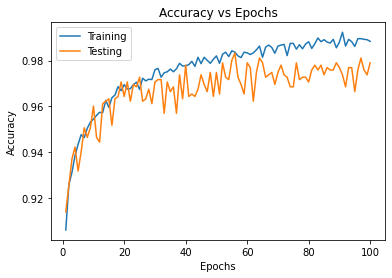

In [4]:
plt.plot(np.arange(1, 101), np.array(train_acc), label = "Training")
plt.plot(np.arange(1, 101), np.array(test_acc), label = "Testing")

plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [5]:
train_loss = []
with open('./trial-11-14-epoch100-bs8/train_loss_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        train_loss.append(value/data_train.shape[0])

test_loss = []
with open('./trial-11-14-epoch100-bs8/test_loss_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        test_loss.append(value/data_test.shape[0])

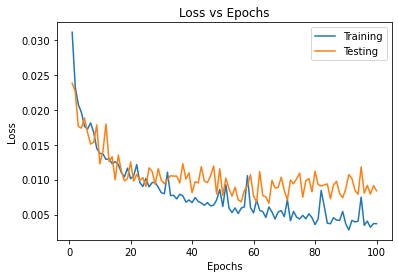

In [6]:
plt.plot(np.arange(1, 101), np.array(train_loss), label = "Training")
plt.plot(np.arange(1, 101), np.array(test_loss), label = "Testing")

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results for 250 Epochs with Batch-Size 8

In [7]:
train_acc = []
with open('./trial-11-14-epoch250-bs8/train_acc_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        train_acc.append(value)
        
test_acc = []
with open('./trial-11-14-epoch250-bs8/test_acc_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        test_acc.append(value)

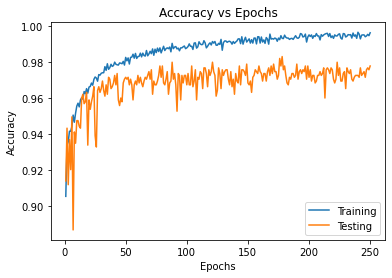

In [8]:
plt.plot(np.arange(1, 251), np.array(train_acc), label = "Training")
plt.plot(np.arange(1, 251), np.array(test_acc), label = "Testing")

plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_loss = []
with open('./trial-11-14-epoch250-bs8/train_loss_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        train_loss.append(value/data_train.shape[0])

test_loss = []
with open('./trial-11-14-epoch250-bs8/test_loss_list.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        value = float(line.strip())
        test_loss.append(value/data_test.shape[0])

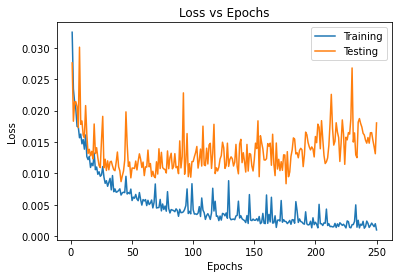

In [10]:
plt.plot(np.arange(1, 251), np.array(train_loss), label = "Training")
plt.plot(np.arange(1, 251), np.array(test_loss), label = "Testing")

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluating Model 

In [11]:
from models import cls_model
from data_loader import get_data_loader
from collections import Counter

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model = cls_model().to(device)
model_path = './checkpoints/cls/best_model.pt'
with open(model_path, 'rb') as f:
    state_dict = torch.load(f, map_location=device)
    model.load_state_dict(state_dict)
model.eval()
print("successfully loaded checkpoint from {}".format(model_path))

successfully loaded checkpoint from ./checkpoints/cls/best_model.pt


## Robustness Testing #1: Sampling

### 10000 Points (Default)

In [14]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 10000, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [15]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [16]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [650],
        [651],
        [670],
        [673],
        [685],
        [701],
        [707],
        [714],
        [716],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914]], device='cuda:0')


In [17]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9832109129066107


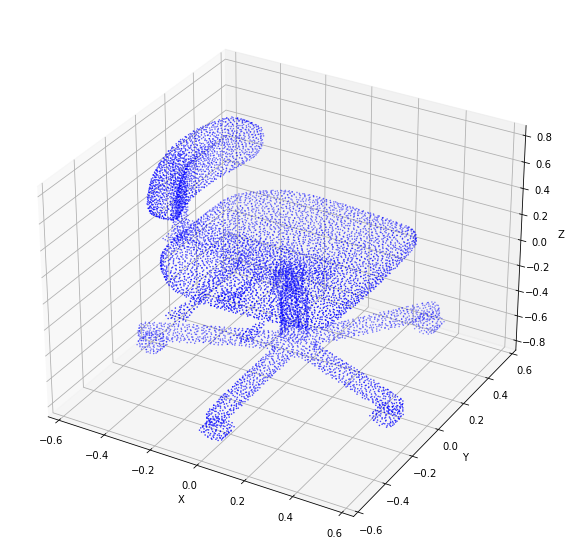

In [18]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [19]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


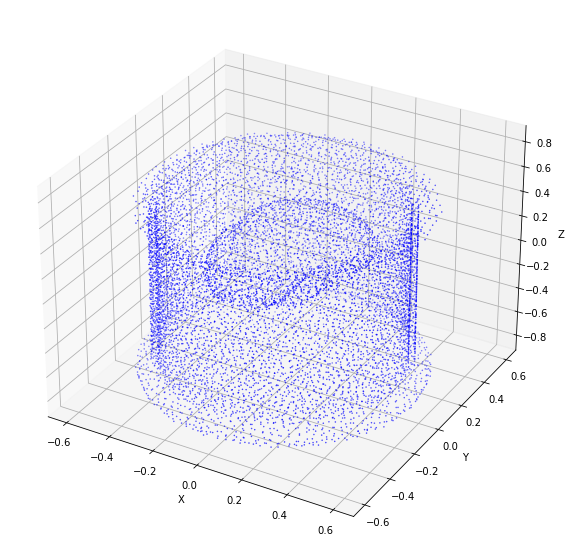

In [20]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [21]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


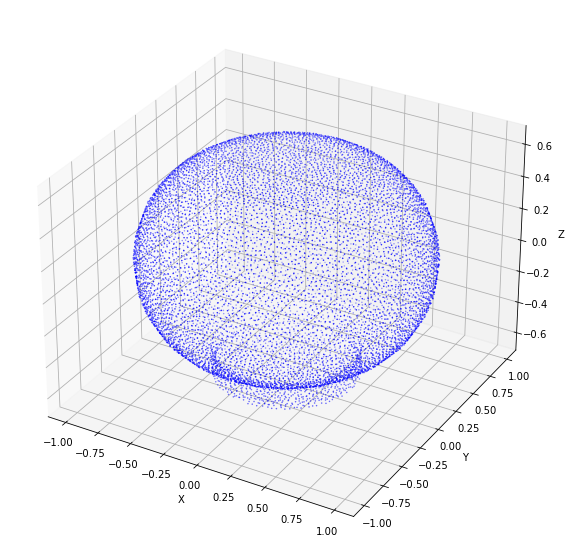

In [22]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [23]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### 7500 Points (75% of Original)

In [24]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 7500, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [25]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [26]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [650],
        [651],
        [670],
        [673],
        [685],
        [701],
        [707],
        [714],
        [716],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914]], device='cuda:0')


In [27]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9832109129066107


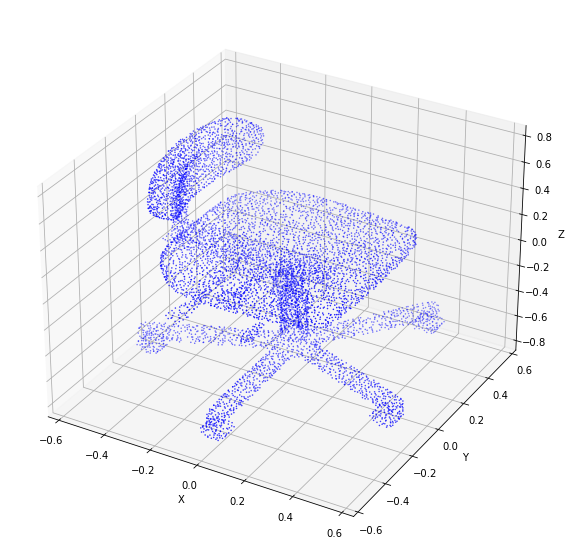

In [28]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [29]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


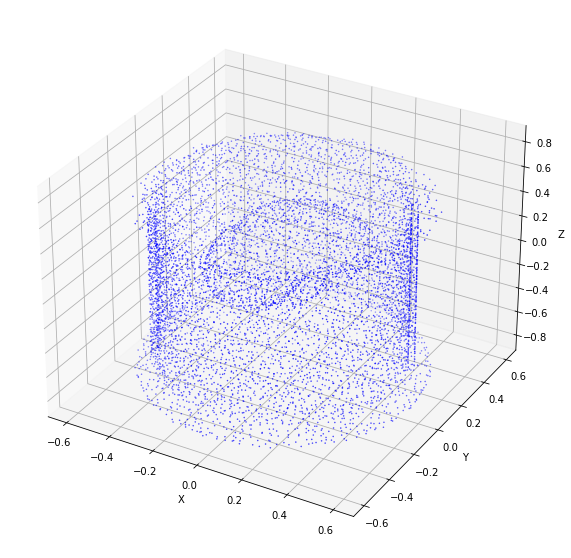

In [30]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [31]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


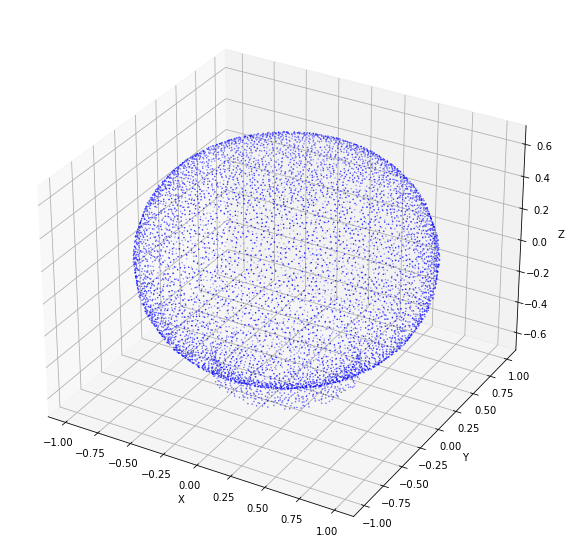

In [32]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [33]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### 5000 Points (50% of Original)

In [34]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 5000, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [35]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [36]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [650],
        [651],
        [670],
        [673],
        [685],
        [701],
        [707],
        [714],
        [716],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914]], device='cuda:0')


In [37]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9832109129066107


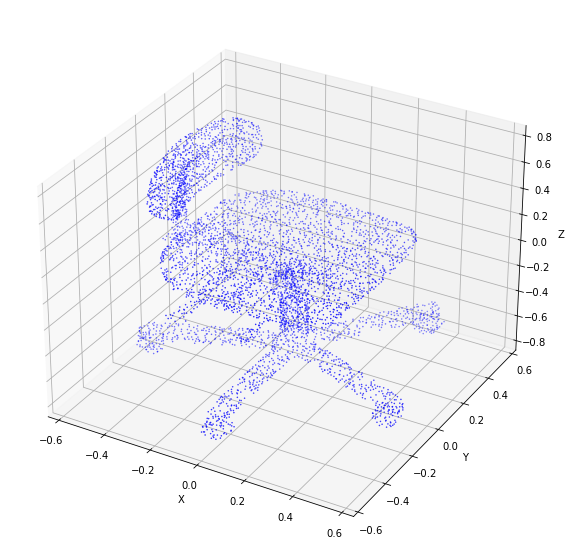

In [38]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [39]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


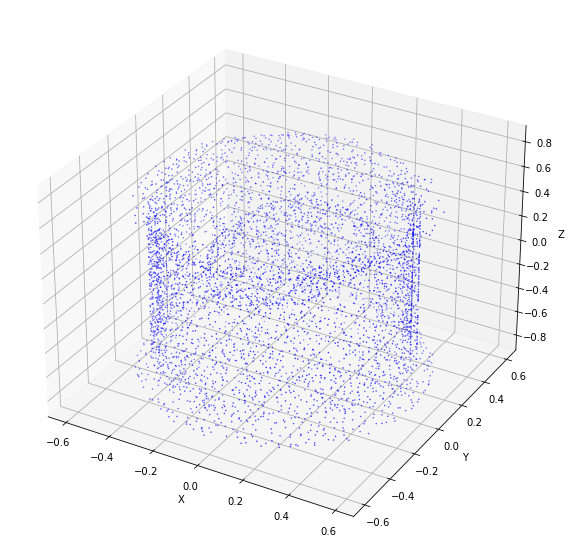

In [40]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [41]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


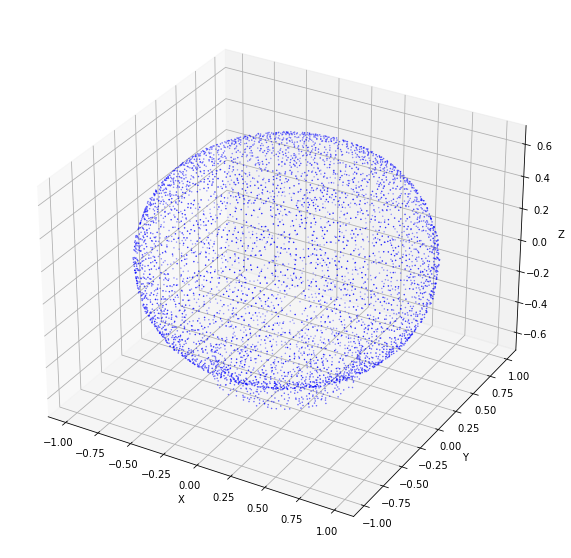

In [42]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [43]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### 2500 Points (25% of Original)

In [44]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 2500, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [45]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [46]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [650],
        [651],
        [670],
        [673],
        [685],
        [697],
        [701],
        [707],
        [714],
        [716],
        [787],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914]], device='cuda:0')


In [47]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9811122770199371


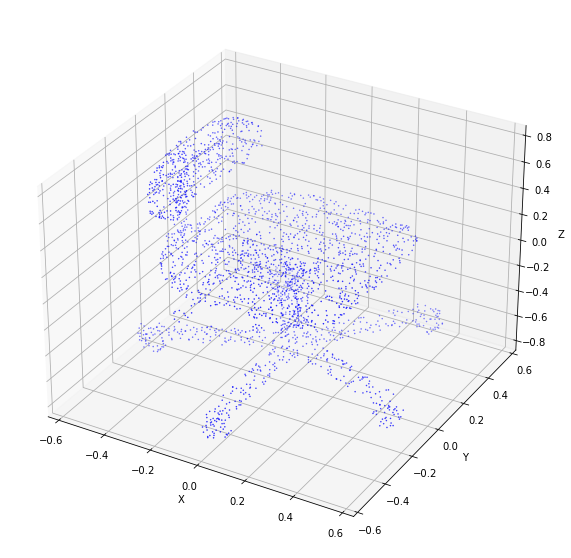

In [48]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [49]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


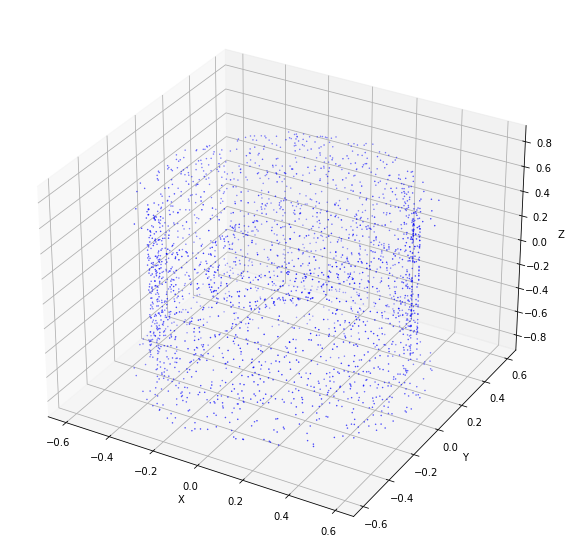

In [50]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [51]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


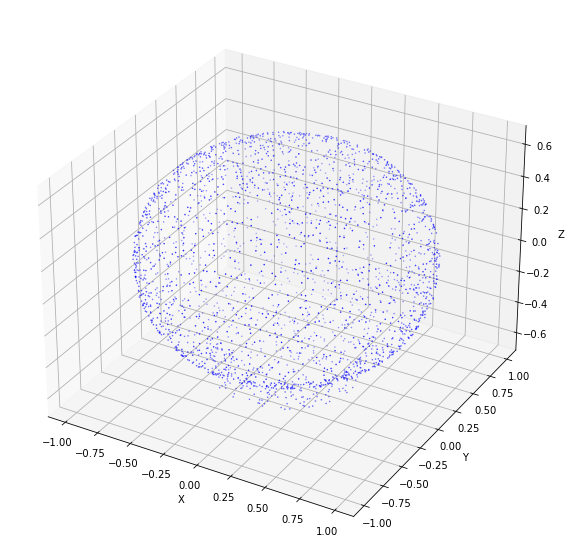

In [52]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [53]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### 1000 Points (10% of Original)

In [54]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 1000, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [55]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [56]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [623],
        [650],
        [651],
        [660],
        [668],
        [670],
        [673],
        [681],
        [685],
        [687],
        [697],
        [701],
        [707],
        [714],
        [716],
        [787],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914]], device='cuda:0')


In [57]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9758656873032528


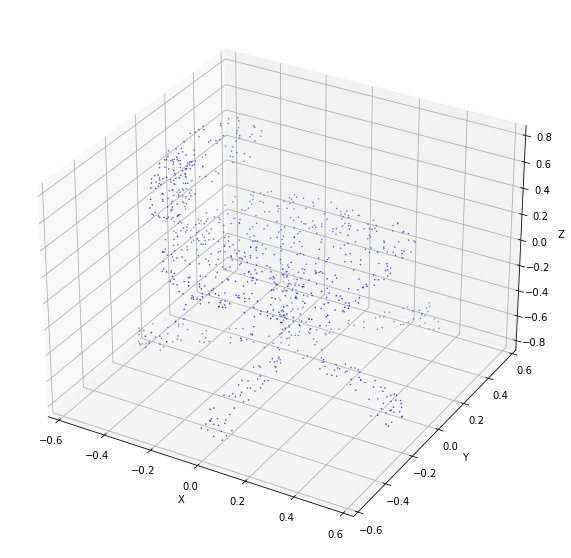

In [58]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [59]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


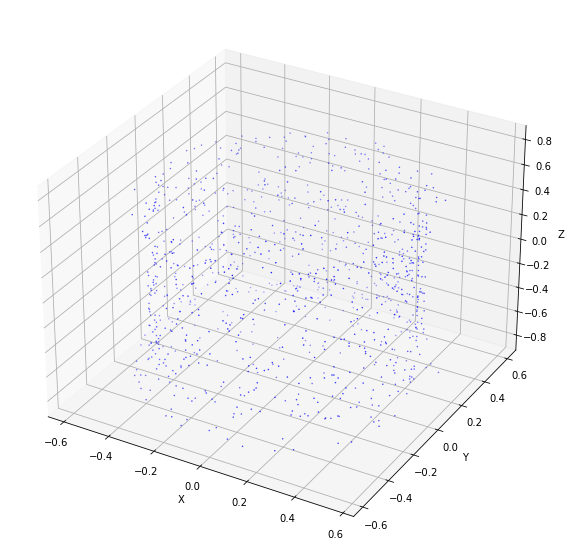

In [60]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [61]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


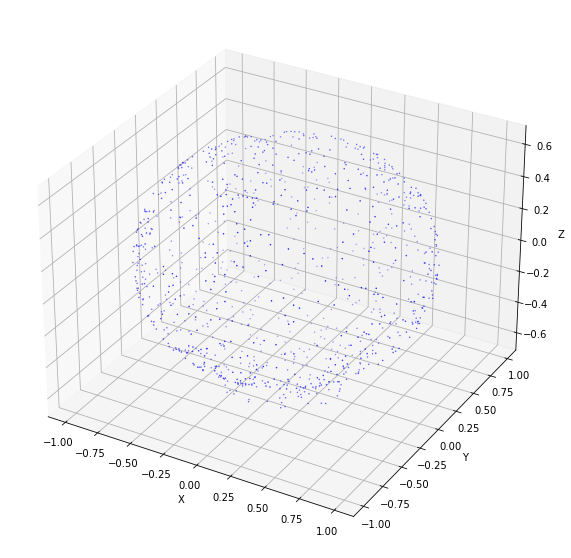

In [62]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [63]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### 500 Points (5% of Original)

In [64]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 500, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [65]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [66]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [619],
        [648],
        [650],
        [651],
        [652],
        [663],
        [664],
        [668],
        [670],
        [673],
        [681],
        [685],
        [687],
        [695],
        [697],
        [699],
        [701],
        [703],
        [706],
        [707],
        [714],
        [716],
        [803],
        [806],
        [827],
        [859],
        [883]], device='cuda:0')


In [67]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9706190975865687


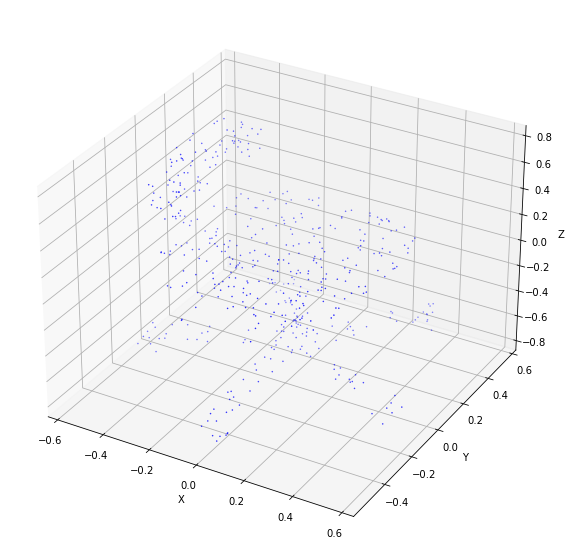

In [68]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [69]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


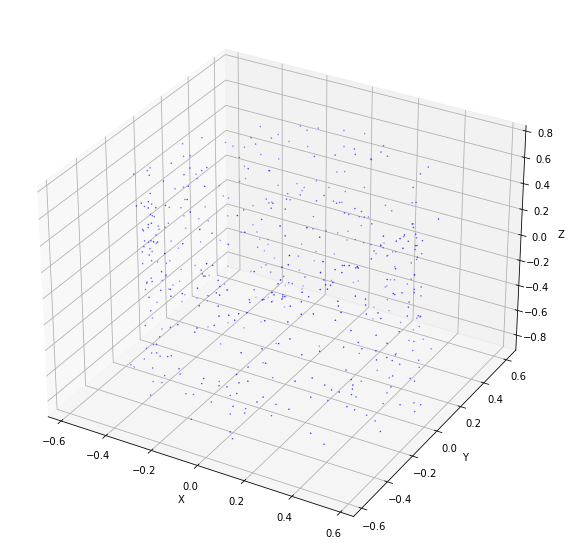

In [70]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [71]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


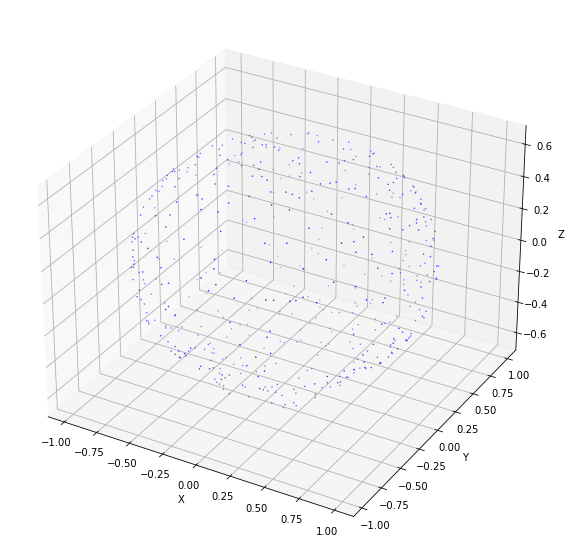

In [72]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [73]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### 100 Points (1% of Original)

In [74]:
# sample points
# default: each cloud has 10000 points 
ind = np.random.choice(10000, 100, replace=False) 
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))[:,ind,:]).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [75]:
pred_labels = []

data_loader = torch.split(test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [76]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[ 51],
        [543],
        [595],
        [618],
        [619],
        [620],
        [621],
        [623],
        [629],
        [631],
        [640],
        [645],
        [646],
        [647],
        [648],
        [651],
        [652],
        [655],
        [656],
        [658],
        [659],
        [663],
        [664],
        [667],
        [668],
        [670],
        [671],
        [673],
        [675],
        [676],
        [678],
        [681],
        [685],
        [687],
        [691],
        [695],
        [696],
        [697],
        [699],
        [701],
        [702],
        [703],
        [704],
        [707],
        [716],
        [750],
        [787],
        [806],
        [827],
        [870],
        [940]], device='cuda:0')


In [77]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9464847848898216


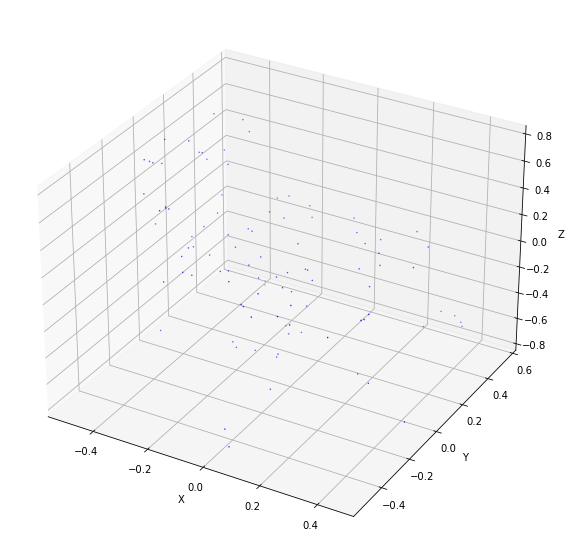

In [78]:
point_cloud = test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [79]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


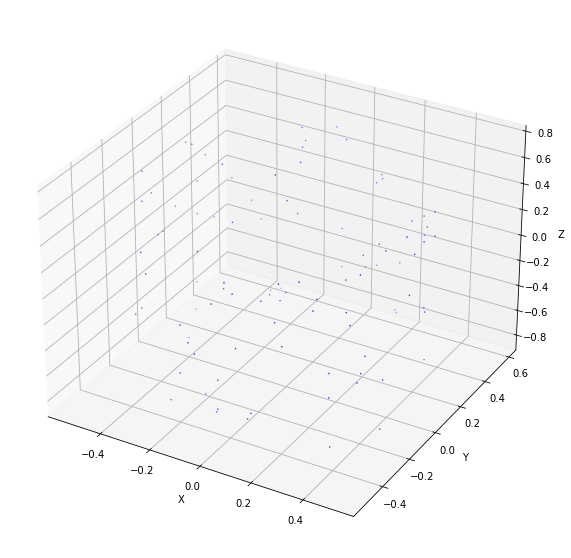

In [80]:
point_cloud = test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [81]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


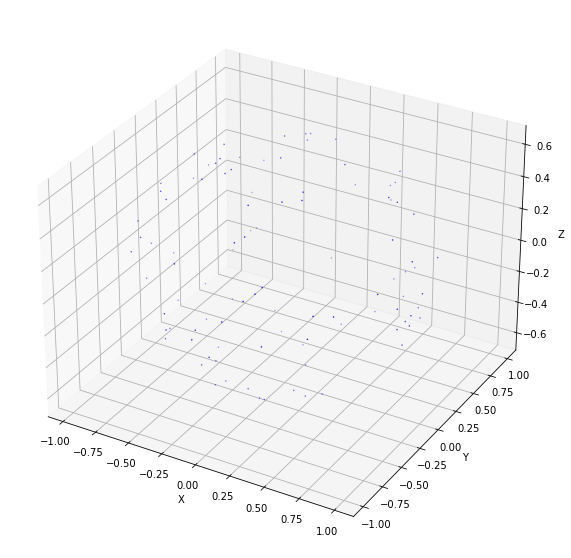

In [82]:
point_cloud = test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [83]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 2
ground truth: 2


## Robustness Testing #2: Rotations

In [84]:
import torch
import torch.nn.functional as F
import math

In [85]:
test_data = torch.from_numpy((np.load('./data/cls/data_test.npy'))).to(device)
test_label = torch.from_numpy(np.load('./data/cls/label_test.npy')).to(device).to(torch.long)

In [86]:
def rotate_point_cloud(point_cloud, rotation_matrix):
    """
    rotate a point cloud using a rotation matrix
    """
    # perform matrix rotation operation 
    rotated_point_cloud = torch.matmul(point_cloud, rotation_matrix.transpose(1, 2))

    return rotated_point_cloud

### Set Rotations (0 Degrees)

In [87]:
degrees = 0

R0 = torch.tensor([
    [math.cos(math.radians(degrees)), -math.sin(math.radians(degrees)), 0],
    [math.sin(math.radians(degrees)), math.cos(math.radians(degrees)), 0],
    [0, 0, 1]
], dtype=torch.float32).to(device)  # 45 degrees rotation 
R0 = R0.unsqueeze(0).expand(test_data.size(0), -1, -1)  # Tile the rotation matrix for each batch
rotated_test_data = rotate_point_cloud(test_data, R0)

In [88]:
pred_labels = []

data_loader = torch.split(rotated_test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [89]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [650],
        [651],
        [670],
        [673],
        [685],
        [701],
        [707],
        [714],
        [716],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914]], device='cuda:0')


In [90]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9832109129066107


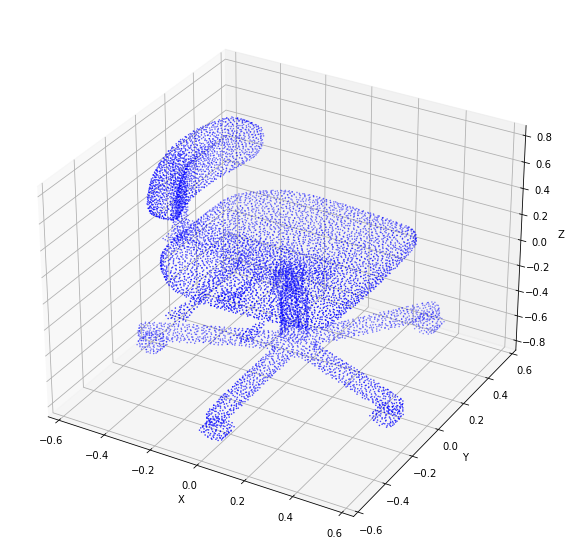

In [91]:
point_cloud = rotated_test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [92]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


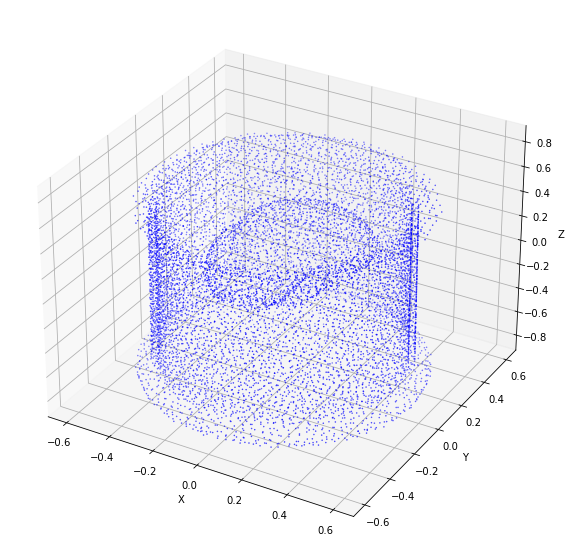

In [93]:
point_cloud = rotated_test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [94]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


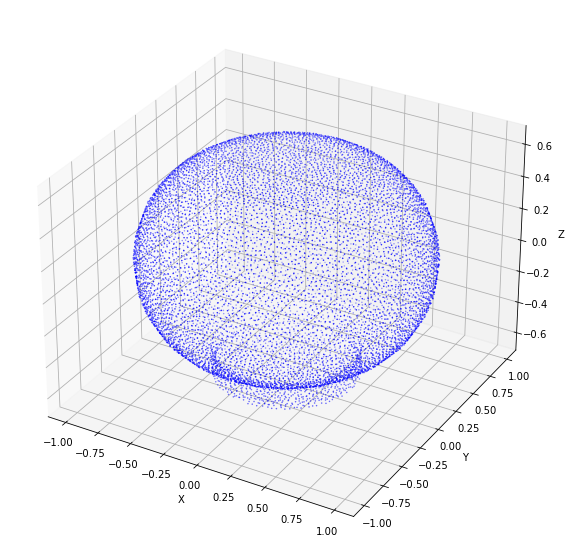

In [95]:
point_cloud = rotated_test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [96]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### Set Rotations (5 Degrees)

In [97]:
degrees = 5

R0 = torch.tensor([
    [math.cos(math.radians(degrees)), -math.sin(math.radians(degrees)), 0],
    [math.sin(math.radians(degrees)), math.cos(math.radians(degrees)), 0],
    [0, 0, 1]
], dtype=torch.float32).to(device)  # 45 degrees rotation 
R0 = R0.unsqueeze(0).expand(test_data.size(0), -1, -1)  # Tile the rotation matrix for each batch
rotated_test_data = rotate_point_cloud(test_data, R0)

In [98]:
pred_labels = []

data_loader = torch.split(rotated_test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [99]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[618],
        [650],
        [651],
        [673],
        [685],
        [701],
        [707],
        [714],
        [716],
        [787],
        [803],
        [806],
        [827],
        [859],
        [883],
        [914],
        [916],
        [931]], device='cuda:0')


In [100]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.9811122770199371


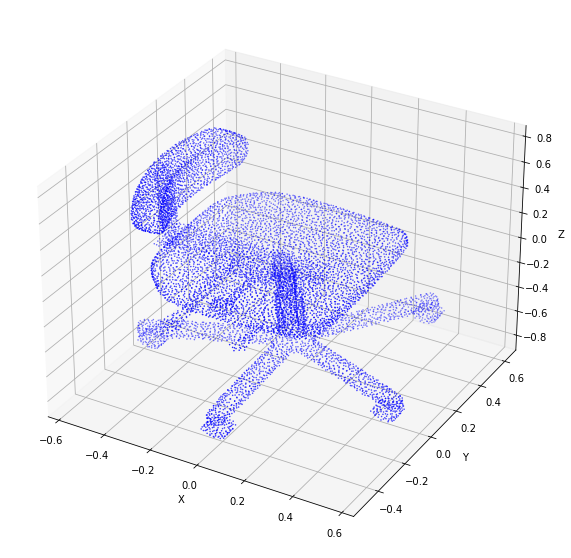

In [101]:
point_cloud = rotated_test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [102]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 0
ground truth: 0


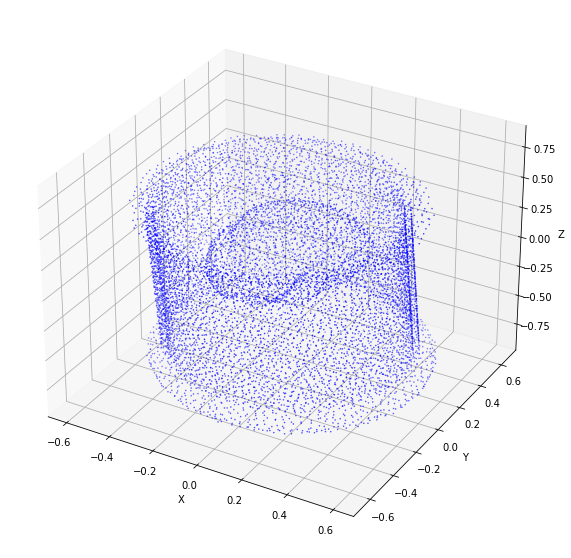

In [103]:
point_cloud = rotated_test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [104]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 2
ground truth: 1


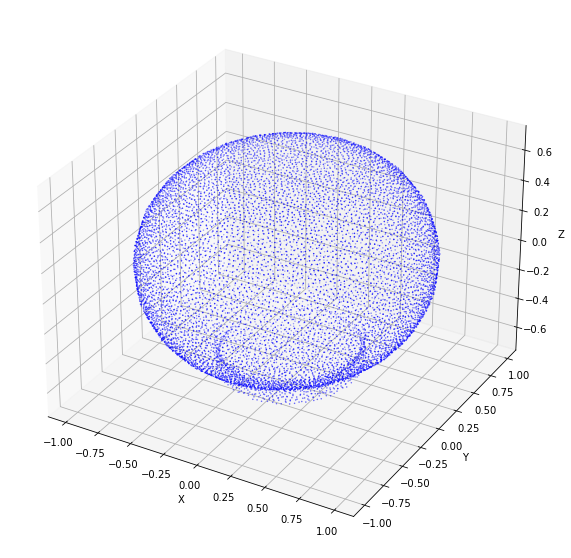

In [105]:
point_cloud = rotated_test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [106]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2


### Set Rotations (30 Degrees)

In [107]:
degrees = 30

R0 = torch.tensor([
    [math.cos(math.radians(degrees)), -math.sin(math.radians(degrees)), 0],
    [math.sin(math.radians(degrees)), math.cos(math.radians(degrees)), 0],
    [0, 0, 1]
], dtype=torch.float32).to(device)  # 45 degrees rotation 
R0 = R0.unsqueeze(0).expand(test_data.size(0), -1, -1)  # Tile the rotation matrix for each batch
rotated_test_data = rotate_point_cloud(test_data, R0)

In [108]:
pred_labels = []

data_loader = torch.split(rotated_test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [109]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[  0],
        [  8],
        [ 11],
        [ 12],
        [ 13],
        [ 20],
        [ 28],
        [ 31],
        [ 32],
        [ 36],
        [ 37],
        [ 38],
        [ 41],
        [ 45],
        [ 46],
        [ 49],
        [ 57],
        [ 63],
        [ 67],
        [ 77],
        [ 83],
        [ 84],
        [ 91],
        [ 92],
        [ 93],
        [ 95],
        [ 99],
        [102],
        [103],
        [105],
        [113],
        [115],
        [116],
        [121],
        [122],
        [130],
        [131],
        [137],
        [146],
        [148],
        [149],
        [159],
        [162],
        [167],
        [172],
        [176],
        [177],
        [180],
        [185],
        [190],
        [203],
        [209],
        [215],
        [225],
        [233],
        [235],
        [236],
        [250],
        [251],
        [261],
        [262],
        [266],
        [269],
        [272],
        [276],
        [277],
        [2

In [110]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.7366211962224554


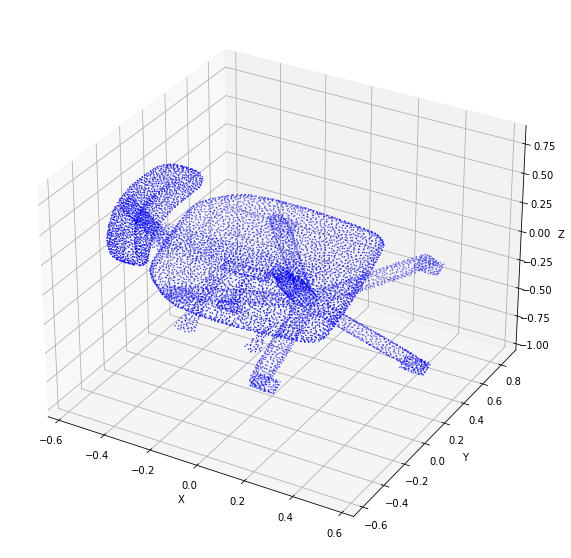

In [111]:
point_cloud = rotated_test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [112]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 1
ground truth: 0


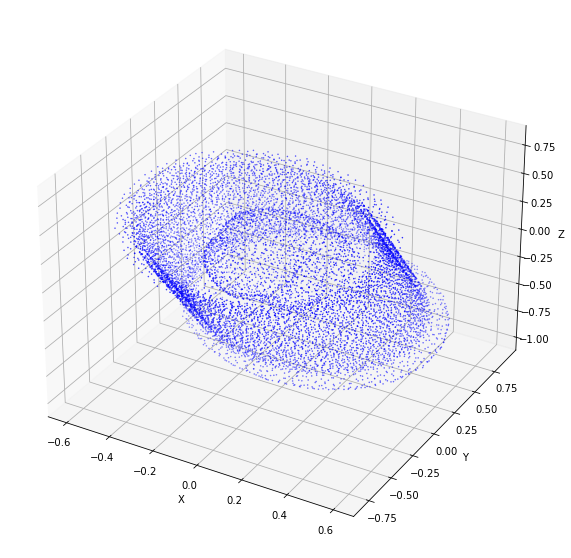

In [113]:
point_cloud = rotated_test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [114]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 1
ground truth: 1


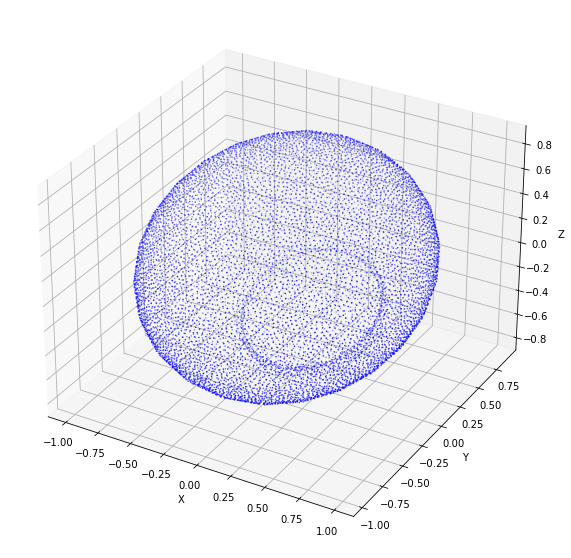

In [115]:
point_cloud = rotated_test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [116]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 2
ground truth: 2


### Set Rotations (45 Degrees)

In [117]:
degrees = 45

R0 = torch.tensor([
    [math.cos(math.radians(degrees)), -math.sin(math.radians(degrees)), 0],
    [math.sin(math.radians(degrees)), math.cos(math.radians(degrees)), 0],
    [0, 0, 1]
], dtype=torch.float32).to(device)  # 45 degrees rotation 
R0 = R0.unsqueeze(0).expand(test_data.size(0), -1, -1)  # Tile the rotation matrix for each batch
rotated_test_data = rotate_point_cloud(test_data, R0)

In [118]:
pred_labels = []

data_loader = torch.split(rotated_test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [119]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[  0],
        [  1],
        [  2],
        [  3],
        [  7],
        [  8],
        [  9],
        [ 11],
        [ 12],
        [ 13],
        [ 18],
        [ 20],
        [ 23],
        [ 25],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 45],
        [ 46],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 58],
        [ 59],
        [ 63],
        [ 65],
        [ 66],
        [ 67],
        [ 70],
        [ 71],
        [ 73],
        [ 74],
        [ 75],
        [ 76],
        [ 77],
        [ 79],
        [ 80],
        [ 83],
        [ 84],
        [ 86],
        [ 87],
        [ 88],
        [ 91],
        [ 92],
        [ 93],
        [ 94],
        [ 95],
        [ 96],
        [ 98],
        [ 

In [120]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.4323189926547744


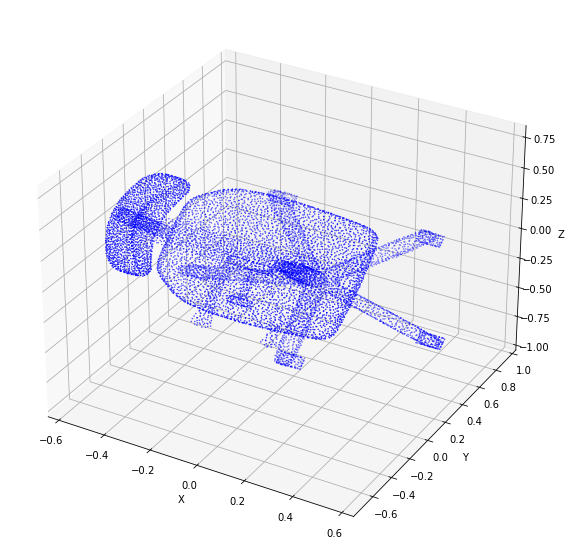

In [121]:
point_cloud = rotated_test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [122]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 1
ground truth: 0


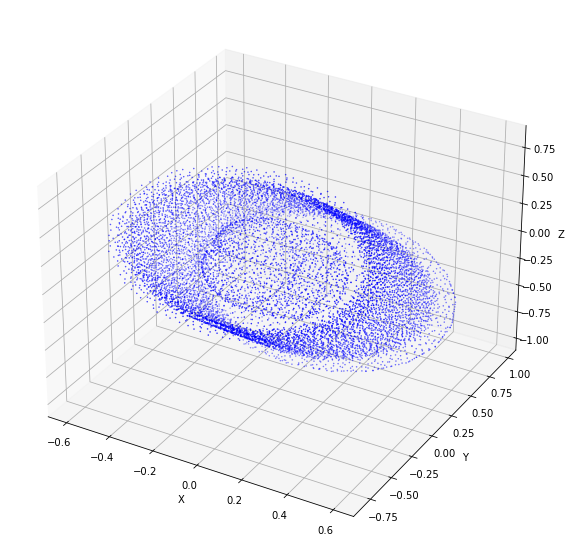

In [123]:
point_cloud = rotated_test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [124]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 1
ground truth: 1


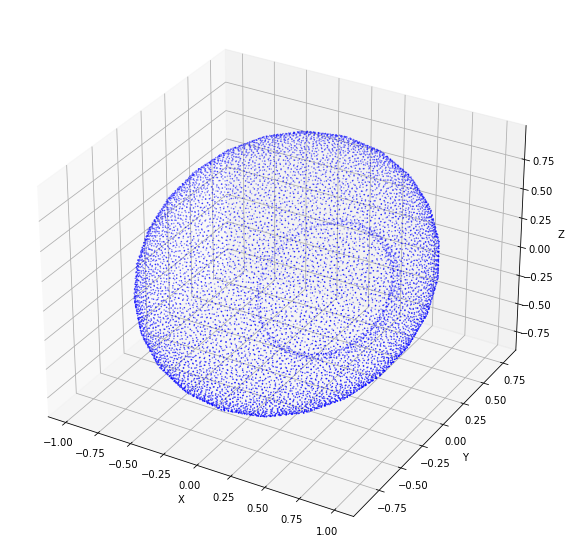

In [125]:
point_cloud = rotated_test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [126]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 2
ground truth: 2


### Set Rotations (90 Degrees)

In [127]:
degrees = 90

R0 = torch.tensor([
    [math.cos(math.radians(degrees)), -math.sin(math.radians(degrees)), 0],
    [math.sin(math.radians(degrees)), math.cos(math.radians(degrees)), 0],
    [0, 0, 1]
], dtype=torch.float32).to(device)  # 45 degrees rotation 
R0 = R0.unsqueeze(0).expand(test_data.size(0), -1, -1)  # Tile the rotation matrix for each batch
rotated_test_data = rotate_point_cloud(test_data, R0)

In [128]:
pred_labels = []

data_loader = torch.split(rotated_test_data, 32)
label_loader = torch.split(test_label, 32)

# load into batches to avoid memory overload
for data, label in zip(data_loader, label_loader):
    pred_label =  model(data)
    pred_label = torch.argmax(pred_label, 1)
    pred_labels.append(pred_label)

# concatenate to form final list for comparison
pred_labels = torch.cat(pred_labels) 
print(pred_labels.shape)

torch.Size([953])


In [129]:
incorrect_labels = torch.nonzero(test_label != pred_labels)
print(incorrect_labels)

tensor([[  0],
        [  1],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 45],
        [ 46],
        [ 47],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 59],
        [ 60],
        [ 61],
        [ 62],
        [ 63],
        [ 64],
        [ 65],
        [ 66],
        [ 67],
        [ 69],
        [ 70],
        [ 

In [130]:
accuracy = (test_label == pred_labels).sum().item()/test_label.shape[0]
print("Accuracy: ", accuracy)

Accuracy:  0.2528856243441763


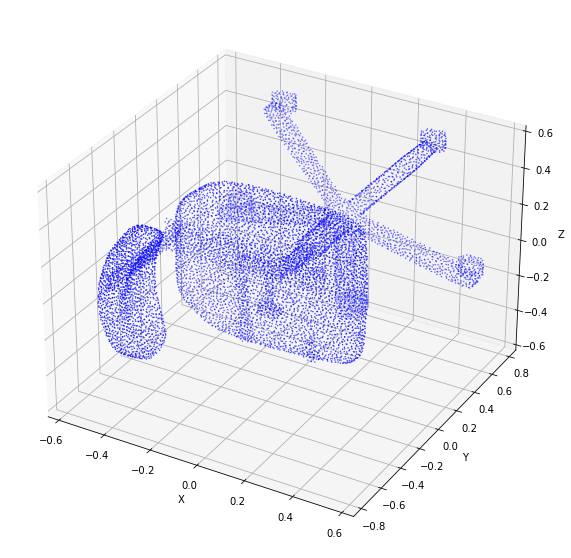

In [131]:
point_cloud = rotated_test_data[146].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [132]:
print("prediction:", pred_labels[146].item())
print("ground truth:", test_label[146].item())

prediction: 2
ground truth: 0


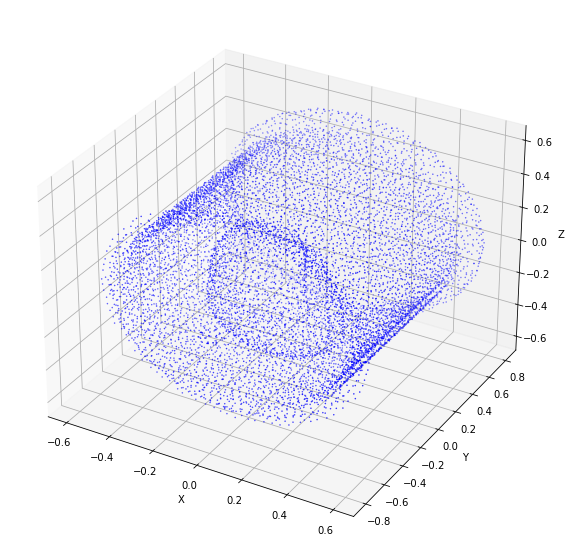

In [133]:
point_cloud = rotated_test_data[618].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [134]:
print("prediction:", pred_labels[618].item())
print("ground truth:", test_label[618].item())

prediction: 1
ground truth: 1


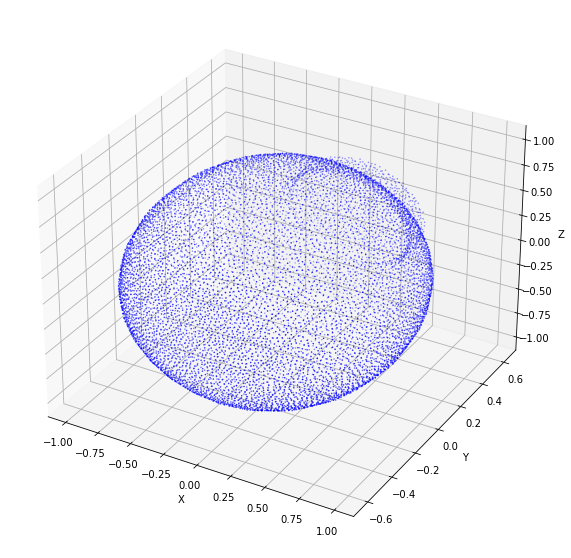

In [135]:
point_cloud = rotated_test_data[883].detach().cpu()

x = point_cloud[:, 2]
y = point_cloud[:, 0]
z = point_cloud[:, 1]

# Create a 3D scatter plot
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='.', s=1)  # You can customize the marker color, style, and size

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [136]:
print("prediction:", pred_labels[883].item())
print("ground truth:", test_label[883].item())

prediction: 1
ground truth: 2
